# Efficient Neural Network Loss Landscape Generation
### Robert Luciani & Hao Huang

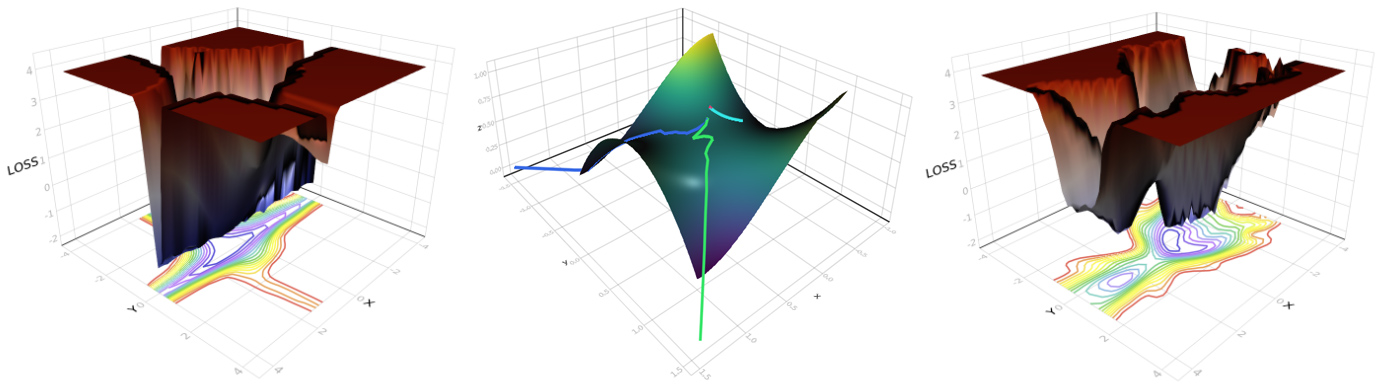

MOTIVATION

Fairly recently we came across the paper by [Li et.al](https://arxiv.org/pdf/1712.09913.pdf) on generating loss surfaces. The plots looked so cool, we immediately wanted to try it ourselves. Unfortunately, the paper's associated GitHub repo had _so much Python code_ for this one task that we didn't have the energy to read through it. With the research paper as a guide and a bit of hacking, we ended up with a few dozen lines of Julia code and some sweet looking plots.

Not to say the two implementations are equivalent, but still, rendering a 51x51 pixel surface is comparatively "interactive" with our code:
```
Reference implementation: 60 minutes on 4x GTX 1080 Ti workstation
This implementation:       2 minutes on GTX 1050 laptop
```

A QUICK PRIMER ON GENERATING LOSS LANDSCAPES

We begin by producing a set of Gaussian random set of weights (a vector) ϕ similar in shape and scale to a trained model θ. We do it again for another random vector ψ. They will act as the x and y axes the final plot. We then do piecewise linear interpolation between the three vectors and plot out the loss at those points. That's basically it!

An intriguing part about this method is that each time the code is run, the generated landscape looks _nearly_ identical. It's a neat result because the vectors that we map to plot axes are chosen essentially at random, with no consideration given to perpendicularity. In theory, assuming the weights of the network are not degenerate, one might be able to solve for two perfectly orthogonal vectors so that the resulting landscape would be more "true". In practice though, the nature of high-dimensional space seems to render such a step unnecessary as any set of random vectors are "orthogonal enough", hence the consistent results. 

THE JULIA PROGRAMMING LANGUAGE

The combined expressiveness and high performance of [Julia](https://julialang.org/) makes it very well suited for Machine Learning work. You can grab mathematical pseudocode from a science book and basically copy it verbatim in Julia, and on the first run it will execute both as intended and blazingly fast. Ultimately, it lets programmers move seamlessly between being mathematicians and computer engineers.

THE FLUX MACHINE LEARNING PACKAGE

Flux provides nearly all convenience functions an ML practitioner might want, including state of the art [autodifferentiation](https://arxiv.org/abs/1810.07951), integration with [ODE solvers](https://arxiv.org/abs/1806.07366), and very elegant [GPU](https://arxiv.org/abs/1712.03112) and [TPU](https://arxiv.org/abs/1810.09868) support. One thing we find especially appealing is that given Flux's pure Julia implementation, all of its functionality is trivially modifiable. 

A DNN in Flux is typically built out of functions like `maxpool` and objects like `Dense`. These convenience objects provided by Flux are essentially structs to keep track of weights, gradients, activations, and so on. Once objects are initialized like `dlayer = Dense(2, 4, σ)` they can be called with input data like `dlayer(dat)`. For feed-forward networks the convenience object `Chain` lets us create a sequence of layers and transformations that we can index into and change easily. For example by creating a mode like `vgg = Chain(Conv, ..., softmax)` you can pass an image through the first five operations like `vgg[1:5](img)`. You can access the bias gradients of the last dense layer like `vgg[29].b.grad`. This flexibility be useful later when we want to do things like overwrite layer weights constantly.

IMPLEMENTATION

We chose the FashionMNIST dataset because it is small enough to be quickly downloaded and complex enough to produce an interesting landscape. Given that batch size affects how a network learns, it follows that the resulting look will be affected by what value is chosen. We want to train the network as we would under ordinary circumstances, which is to say with a full training dataset. However, only a small set of training samples are needed for the final landscape generation step.

In [ ]:
using Flux
using CuArrays

batchsize = 64

dat_x = Flux.Data.FashionMNIST.images(:train)
dat_x = [reshape(Float32.(x), 28, 28, 1, 1) for x in dat_x]
dat_x = gpu.([reduce((x, y)->cat(x, y, dims=4), batch) 
            for batch in Iterators.partition(dat_x, batchsize)])

dat_y = Flux.Data.FashionMNIST.labels(:train)
dat_y = gpu.([Flux.onehotbatch(batch, 0:9) 
            for batch in Iterators.partition(dat_y, batchsize)])

dat = zip(dat_x, dat_y);

We define a VGG-like network with 13 layers, leaky relu activations, and batchnorm. It will easily learn the FashionMNIST dataset in less than one epoch. We set the optimizer to ADAM with η = 0.001 and β = (0.9, 0.999). The loss function is ordinary cross entropy:

$$ H(y, ŷ) = -\sum_{i=1}^{n} \frac{y_i log_2 ŷ_i}{n} $$

In [ ]:
vgg = gpu(Chain(
    Conv((3,3), 1  =>64,  relu, pad=(1,1)), BatchNorm(64),
    Conv((3,3), 64 =>64,  relu, pad=(1,1)), BatchNorm(64), 
    x -> maxpool(x, (2,2)),
    Conv((3,3), 64 =>128, relu, pad=(1,1)), BatchNorm(128),
    Conv((3,3), 128=>128, relu, pad=(1,1)), BatchNorm(128), 
    x -> maxpool(x, (2,2)),
    Conv((3,3), 128=>256, relu, pad=(1,1)), BatchNorm(256),
    Conv((3,3), 256=>256, relu, pad=(1,1)), BatchNorm(256),
    Conv((3,3), 256=>256, relu, pad=(1,1)), BatchNorm(256), 
    x -> maxpool(x, (2,2)),
    Conv((3,3), 256=>512, relu, pad=(1,1)), BatchNorm(512),
    Conv((3,3), 512=>512, relu, pad=(1,1)), BatchNorm(512),
    Conv((3,3), 512=>512, relu, pad=(1,1)), BatchNorm(512), 
    x -> maxpool(x, (2,2)), x -> reshape(x, :, size(x,4)),
    Dense(512,  4096, relu),
    Dense(4096, 4096, relu), Dropout(0.5),
    Dense(4096, 10),
    softmax))

loss(x, y) = Flux.crossentropy(vgg(x), y) 

Flux.train!(loss, params(vgg), dat, ADAM())

We define functions to help us extract, modify, and reinsert arrays into our `Chain` object. We include the weights and biases of both convolutional and dense layers. Other layers such as batchnorm are left as is.

`minweights()` returns a dict with a layer number and its weights/biases:
```
Dict(layer1 => [[W,W,W], [b,b,b]], layer3 => [[W,W], [b,b]])
```
`rdnweights()` returns a similar dict except the weights are Gaussian random and have the same shape/norm as the input model.

In [ ]:
function minweights(layers)
    out = Dict{Int, Array}()
    for i in 1:length(layers)
        if typeof(layers[i]) <: Conv || typeof(layers[i]) <: Dense
            out[i] = getweights(layers[i])
        end
    end
    return out
end

function rndweights(layers, n)
    out = [Dict{Int, Array}() for i in 1:n]
    for θ in out, i in 1:length(layers)
        if typeof(layers[i]) <: Conv || typeof(layers[i]) <: Dense
            w, b = getweights(layers[i])
            d = [gpu(randn(Float32, size(w))), gpu(randn(Float32, size(b)))]
            θ[i] = filternorm(d, getweights(layers[i]))
        end
    end
    return out
end

getweights(layer::T) where T <: Conv =  [copy(layer.weight.data), copy(layer.bias.data)]
getweights(layer::T) where T <: Dense = [copy(layer.W.data), copy(layer.b.data)]

function setweights!(model, weights)
    for (l, w) in weights
        if typeof(model[l]) <: Conv 
            copyto!(model[l].weight.data, w[1]), copyto!(model[l].bias.data, w[2])
        else
            copyto!(model[l].W.data, w[1]), copyto!(model[l].b.data, w[2])
        end
    end
end

The weights in neural networks (especially rectified ones) can be scale invariant and vary wildly between layers. The first thing we need is the ability to normalize vectors so that we can change it by a predictable amount. The robust way to do this is to normalize each filter `j` on each layer `i` in the random vector `ϕ` to the norm of its counterpart in the trained model `θ` like so:

$$ϕ_{i,j} \leftarrow \frac{ϕ_{i,j}}{\left\lVertϕ_{i,j}\right\rVert}\left\lVertθ_{i,j}\right\rVert$$

One can also norm entire layers at a time which is a bit faster but not as smooth.

In [ ]:
layernorm(dir, min) = lnkern.(dir, min)
lnkern(dir, min) = sqrt(sum(min.^2)) .* dir ./ sqrt(sum(dir.^2))

filternorm(dir, min) = fnkern.(dir, min)
function fnkern(dir, min)
    dim = ndims(dir) == 4 ? [1,2,3] : [1]
    sqrt.(sum(min.^2, dims=dim)) .* dir ./ sqrt.(sum(dir.^2, dims=dim))
end

In most circumstances, two random vectors will perturb a given model's loss in fairly similar ways. This means that in order to generate interesting asymmetric landscapes we need to treat the plot axes differently. We can do this by parameterizing asymetrically, norming intermediate vectors, or applying linear interpolation twice.

In [633]:
function linear2x(α, β, θ1, θ2, θ3)
    ψ = α .* θ2 .+ (1-α) .* θ1
    return β .* θ3 .+ (1-β) .* layernorm(ψ, θ1)
end

function barycentric(α, β, θ1, θ2, θ3)
    ϕ  = α .* (θ2 .- θ1) .+ θ1
    ψ  = β .* (θ3 .- θ1) .+ θ1
    return α .* filternorm(ϕ, θ1) .+ (1-β) .* filternorm(ψ, θ1)
end

barycentric (generic function with 1 method)

Below is the entirety of the code that generates the loss landscape. The function `landscape` begins by setting aside the optimized model vector `θm` and generates additional random vectors `θ1, θ2`. It then interpolates between those vectors using the offset parameters `α, β`, creating a new vector `θd` which is reinserted into the model. We then calculate the cross entropy using that vector and store the loss. The last step is simply to replace infinities and log scale the values.

In [ ]:
using ProgressMeter

function landscape(dnn, dat, lbl, res, interpolate)
    x,  y,  z  = collect(res), collect(res), []
    θ1, θ2     = rndweights(dnn, 2)
    θm, θd     = minweights(dnn), Dict()
    @showprogress for α in x, β in y
        for (i, w) in θm
            θd[i] = interpolate(α, β, θm[i], θ1[i], θ2[i])
        end
        setweights!(dnn, θd)
        push!(z, Flux.crossentropy(dnn(dat), lbl).data)
    end
    setweights!(dnn, θm)
    z[isinf.(z)] .= maximum(z[.!(isinf.(z))])
    log.(reshape(z, length(x), length(y)))
end

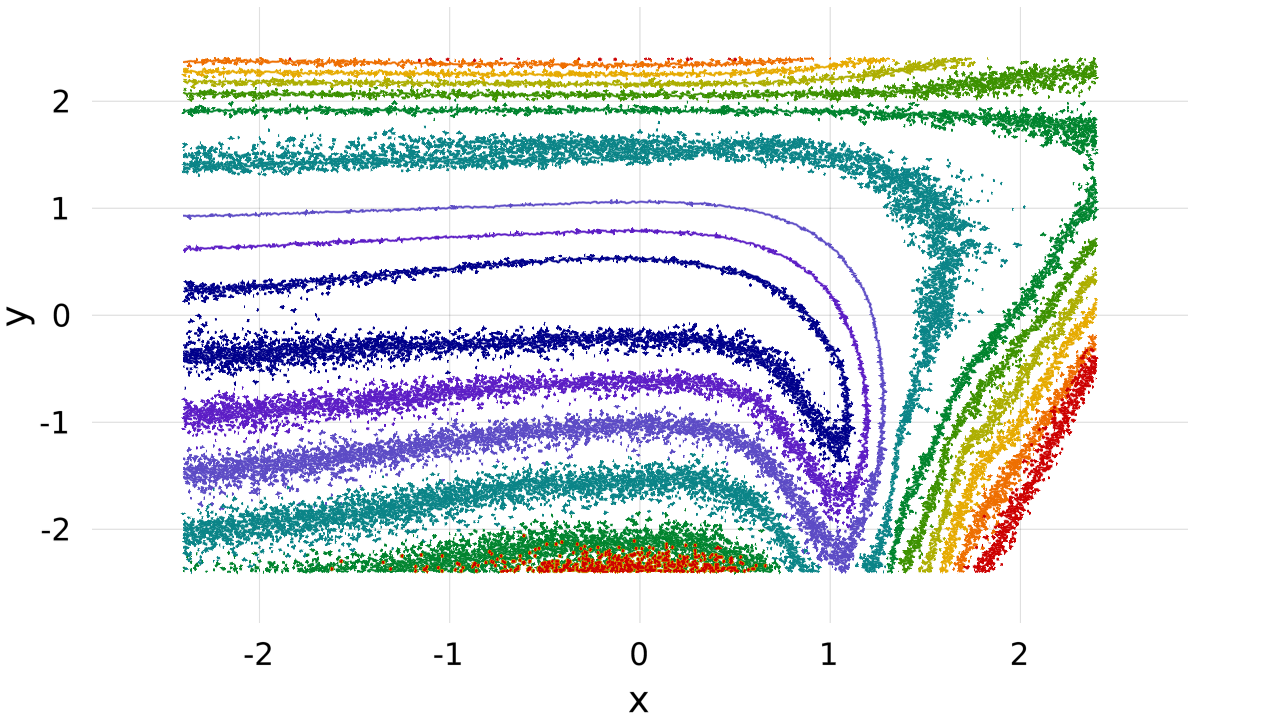

In [657]:
using Makie

res = -2.4f0:0.01f0:2.4f0
zmap = landscape(vgg, dat_x[end], dat_y[end], res, barycentric)

contour(res, res, zmap, levels = 10, linewidth = 2, colormap=:darktest)

# BONUS
DESCENDING INTO THE LOSS ABYSS

We added some functions to convert back and forth between local (manifold) coordinates and zmap indices. This allows us to plot the path that optimizers might take across this sort of landscape. For the interactive sliders to be fun, the optimizer parameters need to be adjusted to match the resolution of the surface.

In [731]:
using Flux.Optimise: apply!

function zdepth(xy, xmap, ymap, zmap)
    x, y = xy.data
    z = 0f0
    try z = zmap[findfirst(v->v>x, xmap)-1, findfirst(v->v>y, ymap)-1]
    catch e end
    return [x, y, z + 0.03] # raise z to increase visibility
end

function zgrad!(xy, xmap, ymap, z)
    x, y = xy.data
    try zx, zy = findfirst(v->v>x, xmap)-1, findfirst(v->v>y, ymap)-1
        xgrad, ygrad = z[zx,zy]-z[zx+1,zy], z[zx,zy]-z[zx,zy+1] 
        copyto!(xy.grad, [xgrad, ygrad])
    catch e end
end

function descend(xy, xres, yres, zmap, opt, steps)
    out = []
    for i in 1:steps
        zgrad!(xy, xres, yres, zmap)
        xy.data .+= apply!(opt, xy.data, xy.grad) 
        push!(out, [zdepth(xy, xres, yres, zmap)...])
    end
    return Point3f0.(out)
end

descend (generic function with 2 methods)

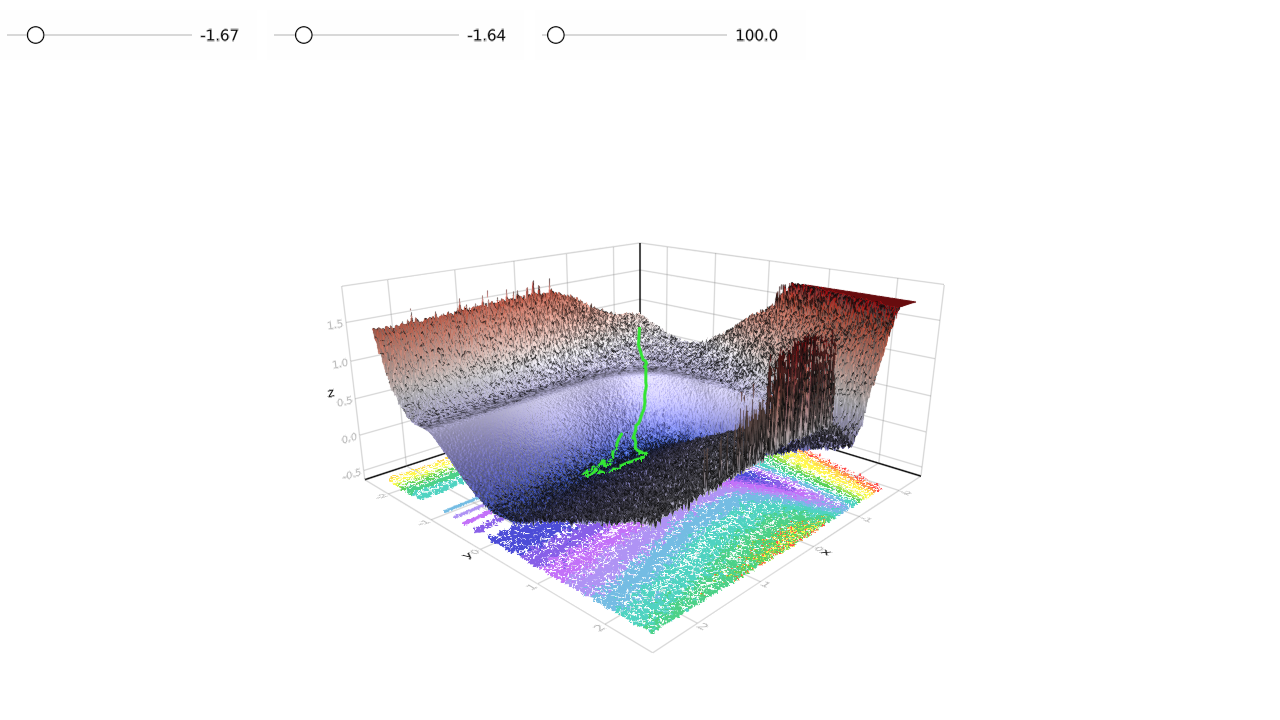

In [732]:
s_x   = slider(res, raw=true, camera=campixel!, start=-1.64f0)
s_y   = slider(res, raw=true, camera=campixel!, start=-1.67f0)
s_opt = slider(30:1:1000, raw=true, camera=campixel!, start=100)

opt   = NADAM(0.2)
path  = lift((x, y, steps) -> descend(param([to_value(x) to_value(y)]), 
            res, res, zmap, opt, to_value(steps)), 
            s_x[end][:value], s_y[end][:value], s_opt[end][:value])

scene = surface(res, res, zmap, colormap=:coolwarm)
scene = lines!(scene, path, color=RGBAf0(0.2, 0.9, 0.2, 1), linewidth=3)
scene = contour!(scene, res, res, zmap, levels = 15, linewidth = 3, 
                transformation = (:xy, minimum(scene.limits[])[3]), colormap=:lighttest)

hbox(scene, vbox(s_y, s_x, s_opt))